In [2]:
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import levy
from scipy.stats import pareto
from scipy.stats import lognorm
from scipy.special import erfc
from numba import jit
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline

Simalate the herfindhl for Pareto distribution. 

$$h = \big[\sum_{i=1}^{N} (\frac{S_{it}}{Y_t})^2\big]^{0.5} $$
$$Y_t = \sum_{i=1}^{N} S_{it} $$

Except for $\zeta=1$, also assume that $\zeta$ is 1.059 following Axtell(2001).

In [4]:
σ_π = 0.12
a = 1
ζ = 1  # Zipf's law
x0 = a**(1/ζ)
N = 1000000
sim = 1000

In [5]:
@njit(parallel=True)
def herfindahl(nSim, ζ, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = (np.random.pareto(ζ, N) + 1) * x0         
        h[i] = np.sqrt(np.sum(np.square(size / np.sum(size))))

    return h    

h = herfindahl(nSim=1000, ζ=1)
print(np.median(h))

0.12012269209028266


#### Match the mean and median assume that log-normal distribution is zero when $x < \bar{x}$.

Given $\zeta>1$ and the minimum $\bar{x}$, the mean and median are $\frac{\zeta \bar{x}}{\zeta-1}$ and $\bar{x} 2^{1/\zeta}$, respectively.

If the log-normal distribution is $\ln(x) \sim \mathcal{N}(\mu, \,\sigma)$, its mean and median are $\exp(\mu + \frac{\sigma^2}{2})$ and $\exp(\mu)$, repectively.

Let $F_X(x)$ be the cumulative distribution function for log-normal. After setting the minumum value $\bar{x}$ and rescale the probability function, the distribution is 

$$\frac{F_X(x) - F_X(\bar{x})}{1-F_X(\bar{x})}, x\ge 0. $$

Thus, the density is $g(x) = \frac{f_X(x)}{1-F_X(\bar{x})}$, where $f_X(x)$ is the density for log-normal:

$$\frac{1}{\sigma x \sqrt{2\pi}} \exp\{ {-\frac{(\ln{x-\mu})^2}{2\sigma^2}} \}$$

Since $g(x)$ is a scaled $f(x)$, the mean for density g is $\frac{1}{1-F_X(\bar{x})}\exp(\mu + \frac{\sigma^2}{2})$. For the mdeian, using the CDF,

$$\frac{1}{2} =  \frac{F_X(x) - F_X(\bar{x})}{1-F_X(\bar{x})}$$
$$median\,=F_X^{-1}\big[ \frac{1}{2}(1-F_X(\bar{x})) + F_X(\bar{x}) \big] $$

Let $\zeta$ be very close to one but not one(the mean is $\infty$ when $\zeta$ is one). Again, following the assumption for simulation, let $\bar{x}=1$. Then, 

$$\frac{1}{1-F_X(\bar{x})}\exp(\mu + \frac{\sigma^2}{2})= \frac{\zeta}{\zeta-1} $$
$$ 2^{1/\zeta}= F_X^{-1}\big[ \frac{1}{2}(1+F_X(\bar{x})) \big] $$
$$ F_X^{-1}[2 F_X(2^{1/\zeta}) - 1] = \bar{x}$$

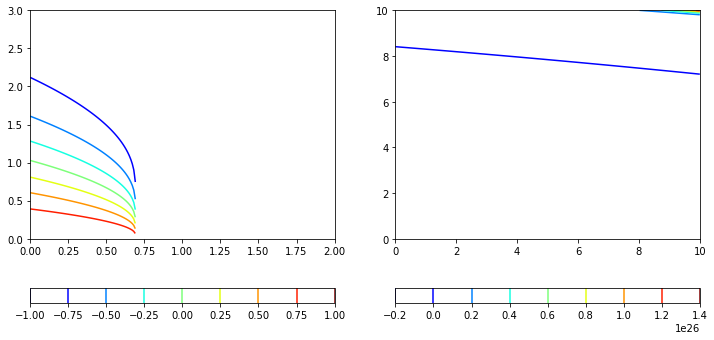

In [50]:
# Solve the equation numerically
eps = np.finfo(float).eps
ζ = 1 + eps

# def obj_median(μ, σ):
#     return - erfc((np.log(2)/ζ - μ)/(np.sqrt(2)*σ))  + erfc(-μ / (np.sqrt(2)*σ)) -1
def obj_median(μ, σ):
    tmp = 2 * lognorm.cdf(2**(1/ζ) ,s=σ,scale=np.exp(μ)) - 1 
    return lognorm.ppf(tmp ,s=σ,scale=np.exp(μ)) - 1

# def obj_mean(μ, σ):
#     return 2 * np.exp(μ + σ**2 / 2) / erfc(-μ / (np.sqrt(2)*σ)) - ζ / (ζ - 1)

def obj_mean(μ, σ):
    return np.exp(μ + 0.5 * σ**2) / (1 - lognorm.cdf(1,s=σ,scale=np.exp(μ))) - ζ / (ζ - 1)

x = np.linspace(eps, 10, 1000)
y = np.linspace(eps, 10, 1000)
xx, yy = np.meshgrid(x, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
z1 = obj_median(xx, yy)
z2 = obj_mean(xx, yy)
contour1 = ax1.contour(xx, yy, z1, cmap = 'jet')
contour2 = ax2.contour(xx, yy, z2, cmap = 'jet')
cbar1 = fig.colorbar(contour1, orientation="horizontal", ax=ax1)
cbar1 = fig.colorbar(contour2, orientation="horizontal", ax=ax2)

ax1.set_xlim(0, 2)
ax1.set_ylim(0, 3)
plt.show()

#### There is no pair of $(\mu, \sigma)$ which can pin down the roots for the mean and median equations at the same time. 

#### Match the mean and median, in the case that there doesn't exit $\bar{x}$ for log-normal.
For mean, 
$$ \frac{\zeta \bar{x}}{\zeta-1} = \exp(\mu + \frac{\sigma^2}{2})$$ 
For median,  

$$\bar{x} 2^{1/\zeta} = \exp(\mu)$$

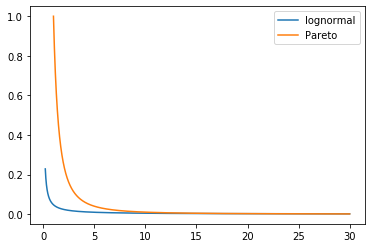

μ=0.69315, σ=8.40839


In [55]:
# Pareto pdf
ζ = 1 + np.finfo(float).eps  # under Zipf's law and the mean is finite
a = 1

f = lambda x: a*ζ / x**(ζ+1)
# lognormal pdf
σ = np.sqrt(2 * (np.log(ζ/(ζ-1)) - 1 / ζ * np.log(2)))
μ = np.log(2) / ζ
g = lambda x: 1/(x*σ*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-μ)**2 / (2*σ**2))

xd = np.linspace(1,30, 100000)
xd2 = np.linspace(0.2, 30, 100000)
plt.plot(xd2, g(xd2), label='lognormal')
plt.plot(xd, f(xd), label='Pareto')
plt.legend()
plt.show()
print('μ=%1.5f, σ=%1.5f'%(μ, σ))

In [52]:
@njit(parallel=True)
def h_lognormal(nSim, mu, sigma, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = np.random.lognormal(mu, sigma, size=N)        
        mask=size>1
        h[i] = np.sqrt(np.sum(np.square(size[mask] / np.sum(size[mask]))))
    return h    


h = h_lognormal(nSim=1000, mu=0.69315, sigma=8.40839)
print(np.median(h))

0.5942463163571974


 $(\mu, \sigma)=(0.69315, 8.40839)$ is shape for matched log-normal under Zipf's law($\zeta$ is close to one but not one). In this case, the herfindahl is 59.42% which is much higher than 12% of Pareto distribution. 
 
 When firm's growth rate is 12%, the growth rate deviation $ \sigma_{GDP} = h\sigma $ is around 7.2% for log-normal which is also higher than 1.4% of Pareto.